In [1]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import scipy.spatial as SS
from scipy.spatial import KDTree
from visualize_graph import *

In [2]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/01 16:09:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext

In [4]:
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    id = np.arange(dim, dtype=int).reshape(dim, 1)
    pos_mass_matrix = np.hstack([id, pos, mass_raw.reshape(dim, 1)])    #np.hstack([pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix



def find_cut(pos_mass_array, percent):

    return np.quantile(pos_mass_array[:, 4], percent)


def mass_filter(pos_mass_cut_rdd):

    mass = pos_mass_cut_rdd[0][:, 4]
    cut = pos_mass_cut_rdd[1]

    return pos_mass_cut_rdd[0][mass >= cut, :]



#def assign_node_id(pos_mass_cut_rdd):
#    pos_mass_array = pos_mass_cut_rdd[0]
#    dim = pos_mass_array.shape
#    #id = np.arange(dim, dtype=int).reshape(dim, 1)
#    #pos_mass_array_stack = np.hstack([id, pos_mass_array[0].reshape(dim, 1), pos_mass_array[1].reshape(dim, 1), pos_mass_array[2].reshape(dim, 1), pos_mass_array[3].reshape(dim, 1)])
#
#    return  dim



def assign_box(point, boxes):
    id, x, y, z, m = point
    box_assign = []
    
    for box_name, ((x_min, x_max), (y_min, y_max), (z_min, z_max)) in boxes.items():
     if (x_min <= x <= x_max) and (y_min <= y <= y_max) and (z_min <= z <= z_max):
           box_assign.append((box_name, point))
    
    return box_assign



# KD-tree to find edges in boxes
def get_edges(pos_mass_points):
    pos_mass_matrix = np.array(pos_mass_points)
    pos = pos_mass_matrix[:,1:4]
    id = pos_mass_matrix[:,0]

    kd_tree = SS.KDTree(pos, leafsize=16, boxsize=1.00001)
    edge_idx = kd_tree.query_pairs(r=0.2, output_type="ndarray")
    edge_idx = np.array([sorted((id[i], id[j])) for i, j in edge_idx])
    
    return edge_idx


# find unique pairs of edges between 2 boxes (pere uniche)
def unique_pears(mat1, mat2):
    mat = np.vstack((mat1, mat2))
    
    return np.unique(mat, axis=0)


In [6]:
# simulations parameters

sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)
sim_pars_list = [(i, j) for i, j in enumerate(sim_pars_file)]
sim_pars_file_rdd = sc.parallelize(sim_pars_list)

In [7]:
N_sims = 100

# path list (key, value)
path_list = [(i, "/mnt/cosmo_GNN/Data/"+str(i)) for i in range(N_sims)]

cosmo_rdd = sc.parallelize(path_list)\
            .mapValues(read_cosmo_data)


In [9]:
cosmo_rdd.take(2)

[(0,
  array([[0.00000000e+00, 6.76912606e-01, 6.60486296e-02, 2.68535763e-01,
          6.35113457e+14],
         [1.00000000e+00, 1.68456003e-01, 6.21953666e-01, 3.80254686e-01,
          4.60181352e+14],
         [2.00000000e+00, 3.19514722e-01, 1.58893153e-01, 3.74134451e-01,
          4.34773265e+14],
         ...,
         [6.23890000e+04, 8.82840753e-01, 9.41545784e-01, 9.32565689e-01,
          7.25836051e+12],
         [6.23900000e+04, 9.62804794e-01, 8.75013113e-01, 9.84234393e-01,
          7.25836051e+12],
         [6.23910000e+04, 9.99761164e-01, 9.24980700e-01, 5.95626363e-04,
          7.25836051e+12]])),
 (1,
  array([[0.00000000e+00, 2.22270206e-01, 6.82273269e-01, 7.60720909e-01,
          1.13813613e+15],
         [1.00000000e+00, 3.21367025e-01, 1.59510881e-01, 3.73064190e-01,
          1.03374206e+15],
         [2.00000000e+00, 6.75490081e-01, 6.58796951e-02, 2.68677831e-01,
          9.20060714e+14],
         ...,
         [2.12941000e+05, 9.62863564e-01, 9.922242

In [11]:
cut_rdd = cosmo_rdd.mapValues(lambda x: find_cut(x, 0.997))


In [12]:
cut_rdd.take(3)

[(0, np.float64(120789282070723.7)),
 (1, np.float64(205680933863424.0)),
 (2, np.float64(153272484626432.0))]

In [13]:
joined_rdd = cosmo_rdd.join(cut_rdd)

In [16]:
joined_rdd.take(2)

[(96,
  (array([[0.00000000e+00, 3.44623357e-01, 8.56006265e-01, 1.41554251e-01,
           1.52590538e+15],
          [1.00000000e+00, 8.19944084e-01, 6.34456575e-02, 6.64648294e-01,
           1.48354653e+15],
          [2.00000000e+00, 1.95964277e-02, 5.93031347e-01, 4.91837025e-01,
           1.18719473e+15],
          ...,
          [1.46528000e+05, 9.09947634e-01, 9.36871648e-01, 9.19337332e-01,
           6.14168737e+12],
          [1.46529000e+05, 9.40787852e-01, 8.71701181e-01, 9.95762229e-01,
           6.14168737e+12],
          [1.46530000e+05, 9.76431072e-01, 9.32554483e-01, 1.11739337e-03,
           6.14168737e+12]]),
   np.float64(232896068122051.62))),
 (0,
  (array([[0.00000000e+00, 6.76912606e-01, 6.60486296e-02, 2.68535763e-01,
           6.35113457e+14],
          [1.00000000e+00, 1.68456003e-01, 6.21953666e-01, 3.80254686e-01,
           4.60181352e+14],
          [2.00000000e+00, 3.19514722e-01, 1.58893153e-01, 3.74134451e-01,
           4.34773265e+14],
        

In [17]:
pos_mass_filtered = joined_rdd.mapValues(mass_filter)\
                                #.filter(lambda x: x is not None)

In [21]:
pos_mass_filtered.take(3)

[(32,
  array([[0.00000000e+00, 1.67560816e-01, 6.14759684e-01, 8.97844359e-02,
          1.95483853e+15],
         [1.00000000e+00, 4.10624981e-01, 1.28075734e-01, 6.64362788e-01,
          1.86257015e+15],
         [2.00000000e+00, 2.01097503e-01, 7.68941715e-02, 6.43602312e-01,
          1.53651542e+15],
         ...,
         [5.26000000e+02, 2.88885951e-01, 3.71629089e-01, 4.13540870e-01,
          3.30010120e+14],
         [5.27000000e+02, 4.24361229e-01, 1.25181004e-01, 3.48667413e-01,
          3.30010120e+14],
         [5.28000000e+02, 6.23156011e-01, 1.39502808e-01, 3.45537812e-01,
          3.30010087e+14]])),
 (0,
  array([[0.00000000e+00, 6.76912606e-01, 6.60486296e-02, 2.68535763e-01,
          6.35113457e+14],
         [1.00000000e+00, 1.68456003e-01, 6.21953666e-01, 3.80254686e-01,
          4.60181352e+14],
         [2.00000000e+00, 3.19514722e-01, 1.58893153e-01, 3.74134451e-01,
          4.34773265e+14],
         [3.00000000e+00, 5.46004772e-01, 8.60320926e-01, 3.019

In [13]:
#pos_mass_filtered.mapValues(assign_node_id).take(1)

In [22]:
cosmo_rdd_filtered = pos_mass_filtered.flatMapValues(lambda x: x)

In [23]:
cosmo_rdd_filtered.filter(lambda x: x[0] == 1).take(10)

# max is 640 for simulation 1

[(1,
  array([0.00000000e+00, 2.22270206e-01, 6.82273269e-01, 7.60720909e-01,
         1.13813613e+15])),
 (1,
  array([1.00000000e+00, 3.21367025e-01, 1.59510881e-01, 3.73064190e-01,
         1.03374206e+15])),
 (1,
  array([2.00000000e+00, 6.75490081e-01, 6.58796951e-02, 2.68677831e-01,
         9.20060714e+14])),
 (1,
  array([3.00000000e+00, 1.69945598e-01, 6.20472789e-01, 3.81364733e-01,
         9.05463328e+14])),
 (1,
  array([4.00000000e+00, 8.62535357e-01, 4.80159279e-03, 7.87378967e-01,
         8.09474768e+14])),
 (1,
  array([5.00000000e+00, 3.29928875e-01, 6.79604352e-01, 8.87155116e-01,
         8.07705376e+14])),
 (1,
  array([6.00000000e+00, 8.02900732e-01, 7.25507915e-01, 5.30599058e-01,
         7.69663844e+14])),
 (1,
  array([7.00000000e+00, 5.46156764e-01, 8.60880971e-01, 3.03565055e-01,
         7.64798048e+14])),
 (1,
  array([8.00000000e+00, 3.14064056e-01, 6.82533562e-01, 8.71255755e-01,
         7.13041008e+14])),
 (1,
  array([9.00000000e+00, 8.90730023e-01, 

In [29]:
min_x, min_y, min_z = 0, 0, 0 #min_coords
max_x, max_y, max_z = 1, 1, 1 #max_coords

r = 0.1  

# Compute the midpoint for every dimension
x_mid = np.mean([min_x, max_x])
y_mid = np.mean([min_y, max_y])
z_mid = np.mean([min_z, max_z])

boxes = {
    "box1": [(min_x    , x_mid + r ), (min_y    , y_mid + r), (min_z    , z_mid + r )],
    "box2": [(x_mid - r, max_x     ), (min_y    , y_mid + r), (min_z    , z_mid + r )],
    "box3": [(min_x    , x_mid + r ), (y_mid - r, max_y    ), (min_z    , z_mid + r )],
    "box4": [(x_mid - r, max_x     ), (y_mid - r, max_y    ), (min_z    , z_mid + r )],
    "box5": [(min_x    , x_mid + r ), (min_y    , y_mid + r), (z_mid - r, max_z    )],
    "box6": [(x_mid - r, max_x     ), (min_y    , y_mid + r), (z_mid - r, max_z    )],
    "box7": [(min_x    , x_mid + r ), (y_mid - r, max_y    ), (z_mid - r, max_z    )],
    "box8": [(x_mid - r, max_x     ), (y_mid - r, max_y    ), (z_mid - r, max_z    )],
}


In [30]:
point_box_rdd = cosmo_rdd_filtered.flatMapValues(lambda p: assign_box(p, boxes))

In [31]:
point_box_rdd.take(3)

[(32,
  ('box3',
   array([0.00000000e+00, 1.67560816e-01, 6.14759684e-01, 8.97844359e-02,
          1.95483853e+15]))),
 (32,
  ('box5',
   array([1.00000000e+00, 4.10624981e-01, 1.28075734e-01, 6.64362788e-01,
          1.86257015e+15]))),
 (32,
  ('box6',
   array([1.00000000e+00, 4.10624981e-01, 1.28075734e-01, 6.64362788e-01,
          1.86257015e+15])))]

In [32]:
#boxes_rdd_sim = point_box_rdd.groupByKey()\
 #                           .mapValues(lambda x: list(x))

In [33]:
#boxes_rdd_sim.take(1)

In [47]:
boxes_rdd = point_box_rdd.map(lambda x: ((x[0], x[1][0]), x[1][1])).groupByKey()\
                        .mapValues(list)
                        #.map(lambda x: (str(x[0]) + '_' + list(x[1])[0], list(x[1])[1]))

In [48]:
boxes_rdd.take(1)

[((76, 'box7'),
  [array([0.00000000e+00, 5.48592448e-01, 7.90772557e-01, 5.33520460e-01,
          1.45681908e+15]),
   array([8.00000000e+00, 1.47536233e-01, 5.62288165e-01, 8.63120079e-01,
          1.01748775e+15]),
   array([1.90000000e+01, 8.69553834e-02, 6.03497326e-01, 4.89825934e-01,
          7.86404150e+14]),
   array([2.80000000e+01, 2.17328891e-01, 4.89993900e-01, 9.21391428e-01,
          7.39832880e+14]),
   array([3.90000000e+01, 3.62822533e-01, 9.03273404e-01, 5.57164252e-01,
          7.02930320e+14]),
   array([4.20000000e+01, 4.80340064e-01, 9.69360948e-01, 6.90055490e-01,
          6.95900935e+14]),
   array([4.90000000e+01, 3.33021671e-01, 9.50360060e-01, 8.14869523e-01,
          6.80084852e+14]),
   array([5.00000000e+01, 3.83471936e-01, 9.08938706e-01, 8.47016871e-01,
          6.80084852e+14]),
   array([5.30000000e+01, 4.82414901e-01, 5.86390853e-01, 9.83822703e-01,
          6.76570159e+14]),
   array([5.70000000e+01, 2.88070202e-01, 4.58953261e-01, 4.430481

In [49]:
edges_rdd = boxes_rdd.mapValues(get_edges)

In [50]:
edges_rdd.take(2)

[((36, 'box5'),
  array([[192., 342.],
         [ 59., 192.],
         [192., 295.],
         ...,
         [ 15., 537.],
         [251., 580.],
         [555., 580.]])),
 ((4, 'box5'),
  array([[214., 307.],
         [227., 307.],
         [307., 345.],
         ...,
         [290., 417.],
         [ 33., 360.],
         [ 33., 290.]]))]

In [51]:
# keep only the number of the simulation as a key

rdd_key_sim = edges_rdd.map(lambda x: (x[0][0], x[1]))        #.map(lambda x: (int(x[0][0]), x[1]))

In [52]:
rdd_key_sim.keys().take(3)#.filter(lambda x: x[0] == 0).take(1)

[36, 4, 68]

In [53]:
#rdd_key_sim.filter(lambda x: x[0]==1).take(1)

In [54]:
final = rdd_key_sim.reduceByKey(lambda a, b: unique_pears(a, b))

In [55]:
#final.filter(lambda x: x[0]==1).take(1)[0][1]

In [61]:
sim = 1
num = pos_mass_filtered.filter(lambda x: x[0] == sim).keys().take(1)[0]
edge_list = final.filter(lambda x: x[0] == sim).values().take(1)[0]
pos_mas_plot = pos_mass_filtered.filter(lambda x: x[0] == sim).values().take(1)[0][:,1:5]
pars = sim_pars_file_rdd.filter(lambda x: x[0] == sim).values().take(1)[0]

In [62]:
edge_list

array([[  0.,   5.],
       [  0.,   8.],
       [  0.,  14.],
       ...,
       [626., 638.],
       [627., 637.],
       [629., 640.]])

In [63]:
pos_mas_plot

array([[2.22270206e-01, 6.82273269e-01, 7.60720909e-01, 1.13813613e+15],
       [3.21367025e-01, 1.59510881e-01, 3.73064190e-01, 1.03374206e+15],
       [6.75490081e-01, 6.58796951e-02, 2.68677831e-01, 9.20060714e+14],
       ...,
       [9.35215056e-01, 3.64688560e-02, 5.38469970e-01, 2.05680934e+14],
       [9.25802767e-01, 8.72740448e-01, 9.68222737e-01, 2.05680934e+14],
       [9.17665958e-01, 9.26170886e-01, 6.67080760e-01, 2.05680934e+14]])

In [64]:
np.max(edge_list)

np.float64(640.0)

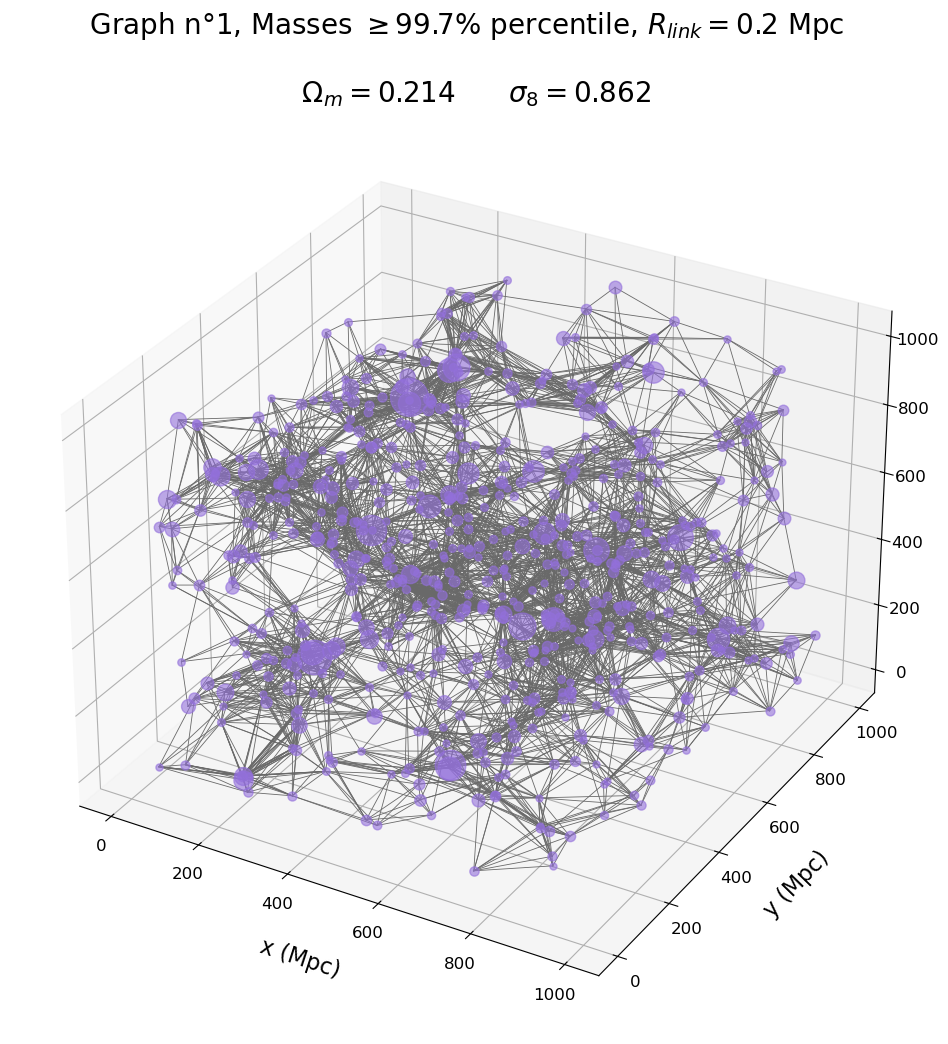

In [65]:
visualize_graph(num, pos_mas_plot, pars, edge_list)

In [76]:
sc.stop()
spark.stop()